# Welcome to the Project C9: KAGGLE - DOG BREED CLASSIFIER

### The aim of the project is to build a model with high performance metrics to classify dog breeds by analyzing their features.

The dataset used contains 120 dog breeds. We will train different models and choose the one with the highest performance.

### Importing libraries

In [228]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import copy
import warnings
warnings.simplefilter(action='ignore')

### Preparation of dataset

In [229]:
#defining function for parsing every image in the dataset

def _parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image = 2*image/255.0-1
    return image, label

##reading data
data = pd.read_csv("labels.csv")
label_to_int = {str(breed): idx for idx, breed in enumerate(data['breed'].unique())}

## Split data into train(80%) and test(20%)
X_train, X_test, y_train, y_test = train_test_split(data.id, data.breed, test_size=0.2, random_state=5)
len_X_test = len(X_test)

y_train = np.asarray([label_to_int[label] for label in y_train]).astype(np.int64)
y_test = np.asarray([label_to_int[label] for label in y_test]).astype(np.int64)


X_train = tf.constant([f'train/{str(image)}.jpg' for image in X_train.values])
y_train = tf.constant(y_train)

#create train dataset and parse using "map"
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.map(_parse_function).batch(17)

X_test = tf.constant([f'train/{str(image)}.jpg' for image in X_test.values])
y_test = tf.constant(y_test)

#create test dataset and parse using "map"
test = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test = test.map(_parse_function).batch(len_X_test)


### Building the classification model : Model 1

The Model 1 is based on MobileNetV2 architecture, which is convolutional neural network mainly known for efficient use for mobile and embedded vision applications. According to reference #1 (see Reference section in the end of the notebook!), the MobileNets has shown strong performance compared to other popular models on ImageNet classification, therefore we have chosen to give a try for classification of dog breed images.

In [31]:
base_layers = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False)
base_layers.trainable = False

In [32]:
model = tf.keras.Sequential([
    base_layers,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(120, activation='softmax')])

In [33]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [34]:
from keras import callbacks
from keras.callbacks import EarlyStopping

earlystopping = callbacks.EarlyStopping(monitor ="loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [35]:
history = model.fit(train, epochs = 15, callbacks =[earlystopping], verbose = 1)

Epoch 1/15
481/481 [==============================] - 144s 295ms/step - loss: 1.4055 - accuracy: 0.6452
Epoch 2/15
481/481 [==============================] - 146s 303ms/step - loss: 0.4314 - accuracy: 0.8756
Epoch 3/15
481/481 [==============================] - 144s 300ms/step - loss: 0.2622 - accuracy: 0.9297
Epoch 4/15
481/481 [==============================] - 144s 299ms/step - loss: 0.1816 - accuracy: 0.9560
Epoch 5/15
481/481 [==============================] - 143s 296ms/step - loss: 0.1280 - accuracy: 0.9742
Epoch 6/15
481/481 [==============================] - 140s 292ms/step - loss: 0.0967 - accuracy: 0.9847
Epoch 7/15
481/481 [==============================] - 139s 290ms/step - loss: 0.0752 - accuracy: 0.9880
Epoch 8/15
481/481 [==============================] - 145s 302ms/step - loss: 0.0608 - accuracy: 0.9916
Epoch 9/15
481/481 [==============================] - 149s 309ms/step - loss: 0.0514 - accuracy: 0.9936
Epoch 10/15
481/481 [==============================] - 150s 312m

### Predicting Model 1 on test data

In [230]:
X_test, y_test = zip(*test)
y_pred = model.predict(X_test[:1])
y_pred_int = [np.argmax(pred) for pred in y_pred]
accuracy = accuracy_score(np.array(y_test)[0], y_pred_int)
print("The accuracy on test data is", accuracy)

64/64 [==============================] - 43s 677ms/step
The accuracy on test data is 0.8117359413202934


### Let's look at training accuracy and loss curves of Model 1

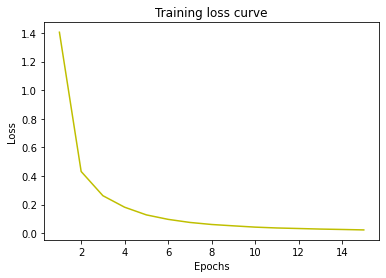

In [38]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

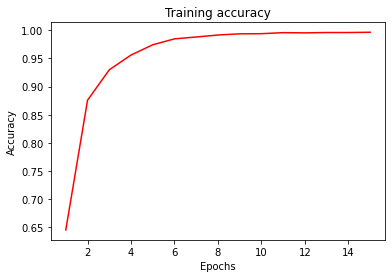

In [40]:
acc = history.history['accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy', c = "r")
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

We can see from the curves that the model efficiently lears by training!

### Let's look at confusion matrix of Model 1! 
#### Since we have 120 breeds (classes) and confusion matrix of 120 classes looks pretty ugly, so here is the example of first 20 classes 

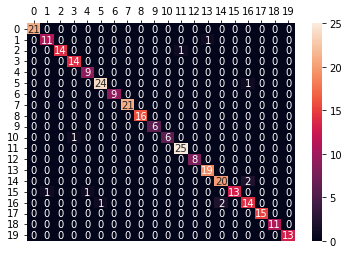

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.array(y_test)[0], y_pred_int)

## An example of confusion matrix for first 20 breeds (classes)
ax = sns.heatmap(cm[:20, :20], annot=True, fmt=".0f")
ax.xaxis.tick_top()

### Performance of classification model: Model 1

In [231]:
from sklearn.metrics import classification_report
print(classification_report(np.array(y_test)[0], y_pred_int))
### numbers back to breeds name

              precision    recall  f1-score   support

           0       0.85      0.92      0.88        25
           1       0.58      0.79      0.67        14
           2       1.00      0.82      0.90        17
           3       0.82      0.82      0.82        17
           4       0.53      0.67      0.59        12
           5       0.92      0.96      0.94        25
           6       0.83      0.91      0.87        11
           7       0.85      0.96      0.90        24
           8       0.68      0.88      0.77        17
           9       0.44      0.80      0.57        10
          10       1.00      0.17      0.29        18
          11       0.71      0.89      0.79        28
          12       0.80      0.67      0.73        12
          13       0.95      1.00      0.97        19
          14       0.90      0.79      0.84        24
          15       0.92      0.57      0.71        21
          16       0.65      0.75      0.70        20
          17       0.94    

### Visually observing some predictions of Model 1 on test data 

In [217]:
def resize_image(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, label


for i in range(16):
    for x in X_test
    ##img = load_img(f'dog-breed-identification/mytest/{i}.jpg')
    img_array = img_to_array(img)
    img_resized, _ = resize_image(img_array, _)
    img_expended = np.expand_dims(img_resized, axis=0)
    prediction = model_2.predict(img_expended)
    breed = [k for k, v in label_to_int.items() if v == np.argmax(prediction[0])][0]
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(breed)

### General Results of performance on classification Model 1.

Training the model with MobileNetV2 architecture has performed learning very efficiently and has achieved training accuracy of 0.9965 in 15 epochs, and on test data has shown accuracy of 0.811. By looking at training loss and accuracy curves, we can be sure that model was learning during the training. According to classification report and confusion matrix, we can also conclude that model is learning and achieves the weighted average precision of 0.83. To observe and confirm the predictions, we have visualised some of the predictions on test data.

### Building the classification model : Model 2

According to reference #2 (see Reference section in the end of the notebook!), ResNet - Residual Neural Network has continued the trend of increasing the depth of the model and it is widely used as it performs really well on classification tasks specifically. Therefore, our Model 2 will be based on ResNet50 architecture.

In [114]:
base_layers_m2 = tf.keras.applications.resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False)
base_layers_m2.trainable = False

In [115]:
model_2 = tf.keras.Sequential([
    base_layers_m2, 
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(120, activation='softmax')])

In [116]:
model_2.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

In [119]:
history_2 = model_2.fit(train, epochs = 15, callbacks =[earlystopping], verbose = 1)

Epoch 1/15
481/481 [==============================] - 510s 1s/step - loss: 4.7635 - accuracy: 0.0147
Epoch 2/15
481/481 [==============================] - 495s 1s/step - loss: 4.7455 - accuracy: 0.0149
Epoch 3/15
481/481 [==============================] - 474s 986ms/step - loss: 4.7305 - accuracy: 0.0168
Epoch 4/15
481/481 [==============================] - 476s 989ms/step - loss: 4.7228 - accuracy: 0.0163
Epoch 5/15
481/481 [==============================] - 473s 983ms/step - loss: 4.7252 - accuracy: 0.0158
Epoch 6/15
481/481 [==============================] - 476s 989ms/step - loss: 4.7070 - accuracy: 0.0175
Epoch 7/15
481/481 [==============================] - 465s 966ms/step - loss: 4.7022 - accuracy: 0.0174
Epoch 8/15
481/481 [==============================] - 466s 968ms/step - loss: 4.6930 - accuracy: 0.0170
Epoch 9/15
481/481 [==============================] - 472s 982ms/step - loss: 4.6884 - accuracy: 0.0185
Epoch 10/15
481/481 [==============================] - 467s 972ms/step

### Predicting Model 2 on test data

In [133]:
X_test, y_test = zip(*test)
y_pred = model_2.predict(X_test[:1])
y_pred_int = [np.argmax(pred) for pred in y_pred]
accuracy = accuracy_score(np.array(y_test)[0], y_pred_int)
print("The accuracy on test data is", accuracy)

64/64 [==============================] - 118s 2s/step
The accuracy on test data is 0.018581907090464547


### Let's look at training accuracy and loss curves of Model 2

In [224]:
loss = history_2.history_2['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

AttributeError: 'History' object has no attribute 'history_2'

In [134]:
acc = history.history_2['accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy', c = "r")
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

AttributeError: 'History' object has no attribute 'history_2'

### Let's look at confusion matrix of Model 2! 
#### Since we have 120 breeds (classes) and confusion matrix of 120 classes looks pretty ugly, so here is the example of first 20 classes 

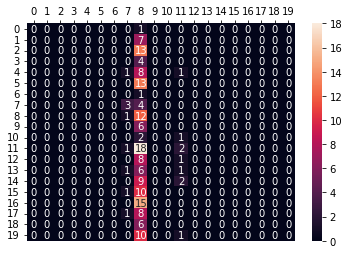

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(np.array(y_test)[0], y_pred_int)

## An example of confusion matrix for first 20 breeds (classes)
ax = sns.heatmap(cm[:20, :20], annot=True, fmt=".0f")
ax.xaxis.tick_top()

### Performance of classification model: Model 2

In [225]:
from sklearn.metrics import classification_report
print(classification_report(np.array(y_test)[0], y_pred_int))
### change numbers back to name of breeds

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        25
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        17
           3       0.00      0.00      0.00        17
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00        25
           6       0.00      0.00      0.00        11
           7       0.06      0.12      0.08        24
           8       0.01      0.71      0.03        17
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00        18
          11       0.08      0.07      0.08        28
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        19
          14       0.00      0.00      0.00        24
          15       0.00      0.00      0.00        21
          16       0.00      0.00      0.00        20
          17       0.00    

### Visually observing some predictions of Model 2 on test data 

In [ ]:
def resize_image(img, label):
    img = tf.cast(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    img = img / 255.0
    return img, label

for i in range(16):
    img = load_img(f'dog-breed-identification/mytest/{i}.jpg')
    img_array = img_to_array(img)
    img_resized, _ = resize_image(img_array, _)
    img_expended = np.expand_dims(img_resized, axis=0)
    prediction = model_2.predict(img_expended)
    breed = [k for k, v in label_to_int.items() if v == np.argmax(prediction[0])][0]
    plt.subplot(4,4,i+1)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    plt.xlabel(breed)


### General Results of performance on classification Model 2.

## Conclusion

# References
1. https://arxiv.org/abs/1704.04861v1
2. https://www.superb-ai.com/blog/how-to-select-better-convnet-architectures-for-image-classification-tasks
3. https://www.youtube.com/watch?v=PHdw0Uk_Lc4